## Сборный проект

### Навигация по проекту
1. [Изучение общей информации](#section1)
2. [Подготовка данных](#section2)
3. [Анализ данных](#section3)
    - [Исследование платформ](#section3.1)
    - [Исследование оценок пользователей и критиков](#section3.2)
    - [Исследование жанров](#section3.3)
    - [Выручка](#section3.4)
    - [Вывод](#section3.5)
4. ["Портрет" пользователя каждого региона](#section4)
5. [Проверка гипотез](#section5)
    - [Гипотеза №1](#section5.1)
    - [Гипотеза №2](#section5.2)
5. [Общий вывод](#section6)

### Импортируем необходимые модули

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math

<a id='section1'></a>
### Откроем данные и изучим общую информацию

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# посмотрим на количество пропусков
total = games.isnull().sum().sort_values(ascending=False) # переменная total, содержащая количество пропусков для каждого признака
percent = (games.isnull().sum() / games.isnull().count()).sort_values(ascending=False) # доля пропусков для каждого признака
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total missing values', 'Percent %'])
missing_data['dtype'] = games.dtypes
missing_data

,Total missing values,Percent %,dtype
Critic_Score,8578,0.513192,float64
Rating,6766,0.404786,object
User_Score,6701,0.400897,object
Year_of_Release,269,0.016093,float64
Genre,2,0.000120,object
Name,2,0.000120,object
Other_sales,0,0.000000,float64
JP_sales,0,0.000000,float64
EU_sales,0,0.000000,float64
NA_sales,0,0.000000,float64


In [5]:
# посмотрим на количество дубликатов в данных
games.duplicated().sum()

0

In [6]:
games['Name'].unique().shape

(11560,)

In [7]:
# посмотрим на количество значений у некоторых признаков
games['Rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: Rating, dtype: int64

In [8]:
games['Genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: Genre, dtype: int64

In [9]:
games['User_Score'].value_counts()[:5]

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
Name: User_Score, dtype: int64

В данном датасете представлено **16715** объектов. **11** признаков.\
Заметим, что несмотря на 16715 объектов, уникальных названий игр **11560**.\
В данных есть пропуски, в частности, меньше всего пропусков у признаков **Name** и **Genre** - по два. Больше всего пропусков у признака **Critic_score** - пропущено **8578** объектов (больше 50% от общего числа). Также много пропусков у признаков **Rating** и **User_Score** - **6766** и **6701** соответственно.\
Обратим внимание, что у признака **User_Score** есть значения `tbd` несмотря на то, что подразумевается, что данный признак содержит только числа.\
На данный момент дубликатов в данных нет.

<a id='section2'></a>
### Подготовка данных

In [10]:
# приведем названия столбцов к нижнему регистру
games.columns = games.columns.str.lower()
games.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


Прежде, чем изменить тип данных у некоторых признаков, заполним пропуски.
Рассмотрим признак **Rating**. У данного признака 40% пропусков от общего числа объектов. Это значит, что просто так удалить данные строки мы не можем, так как уберем большое количество объектов. Заполнять по каким-либо критериям данный признак тоже не просто. Поэтому заменим пропуски, как "не определен" (`notdef`).\
Признаки **Name**, **Genre** и **Year_of_release** содержат меньше 2% пропусков от общих данных, поэтому данные пропуски можно удалить.\
Как было замечено выше, признак **User_score** содержит значения `tbd`, для начала заменим их на `None`.\
Так как у признаков **User_score** и **Critic_score** более 40% пропусков, то не будем заполнять их, чтобы не смещать распределение и дисперсию.

Прежде, чем удалить объекты с пропущенными значениями, посмотрим не содержат ли они какую-либо нужную информацию.

In [11]:
games.loc[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [12]:
games.loc[games['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим, что у двух объектов есть пропуски сразу по нескольким признакам. Они не содержат какую-либо уникальную информацию (объектов платформы GEN в данных больше 2), поэтому их можно спокойно удалить.

In [13]:
games.loc[games['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [14]:
print(games['platform'].unique().shape[0] == games.dropna(subset=['year_of_release'], axis=0)['platform'].unique().shape[0])
print(games['genre'].unique().shape[0] == games.dropna(subset=['year_of_release'], axis=0)['genre'].unique().shape[0])
print(games['rating'].unique().shape[0] == games.dropna(subset=['year_of_release'], axis=0)['rating'].unique().shape[0])

True
True
True


На мой взгляд, в данном случае стоило проверить не потеряем ли мы лишние платформы, жанры и возрастные категории. Как видно выше, уникальные значения по каждому из признаков остались прежними. Таким образом, пропущенные данные тоже можно безболезненно удалить.

In [15]:
#отфильтруем данные
print('До:', games.shape)
games = games.dropna(subset=['name', 'genre', 'year_of_release'], axis=0)
print('После:', games.shape)

До: (16715, 11)
После: (16444, 11)


In [16]:
# заменим пропуски у признака Rating
games['rating'] = games['rating'].fillna('notdef')
#games.loc[games['rating']=='nan', 'rating'] = 'notdef'

In [17]:
# заменим значение tbd на None у признака user_score
games.loc[games['user_score'] == 'tbd', 'user_score'] = None

In [18]:
# заменим тип данных в столбцах year_of_release и user_score
games['critic_score'] = games['critic_score'].astype('Int64')
games['year_of_release'] = games['year_of_release'].astype('int64')
games['user_score'] = games['user_score'].astype('float64')

In [19]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null Int64
user_score         7463 non-null float64
rating             16444 non-null object
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 1.5+ MB


В результате были проведены все необходимые действия по обработке пропусков и изменению типов данных.\
Объяснение по способу заполнения/незаполнения пропусков описано выше.\
**Почему эти пропуски появились?**\
На мой взгляд, пропуски в столбцах **critic_score** и **user_score** образовались из-за того, что критики и пользователи не ставили свои оценки по всем приведенным играм (как в принципе это часто бывает, при просьбе оценить приложение/работу специалиста/что-либо еще). В случае с рейтингом данные также могли быть просто незаполнены.\
**Почему заменил тип данных?**\
В столбцах **year_of_release**, **user_score** и **critic_score** был заменен тип данных.\
В первом случае признак содержит в себе год выхода игры, но имел тип `float`, год - число целочисленное, поэтому данный столбец был приведен к типу `int`.\
Во втором случае признак имел тип object, так как содержал в себе значения `tbd`. Они были заменены на `None`, после чего признак был приведен к типу `float`, так как оценки пользователей могут быть вещественными.\
В третьем случае признак имел тип `float`, хотя содержит в себе только целочисленные значения, поэтому я привел его к типу `int`.

In [20]:
# посчитаем суммарные продажи во всех регионах
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [21]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,notdef,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,notdef,31.38


<a id='section3'></a>
### Исследовательский анализ данных

In [22]:
# посмотрим, сколько игр выпускалось в разные годы
year_release_grouped = games.pivot_table(index='year_of_release', values='name', aggfunc='count')
year_release_grouped

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


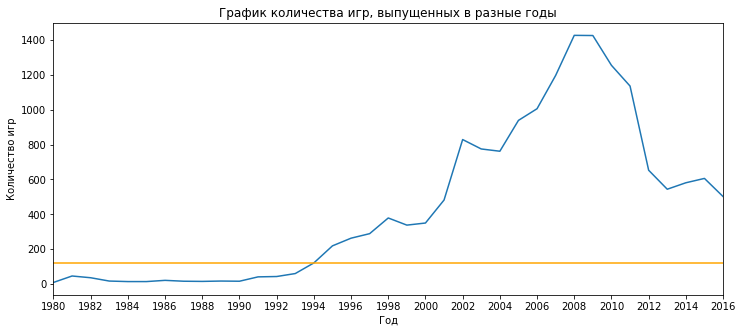

In [23]:
year_release_grouped.plot(figsize=(12,5), legend=False)
plt.xticks(np.arange(1980, 2018, step=2))
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.title('График количества игр, выпущенных в разные годы')
plt.axhline(y = 121, color='orange')
plt.show()

На мой взгляд, данные за все периоды не так важны. Можно заметить, что достаточно резкий скачок по количеству выпущенных игр произошел в **1994** году, когда количество игр превысило сотню.

In [24]:
# посмотрим, как менялись продажи по платформам
platform_grouped = games.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum').reset_index()
platform_grouped = platform_grouped.sort_values(by='total_sales', ascending=False)
platform_grouped[:10]

,platform,year_of_release,total_sales
134,PS2,2004,211.81
200,Wii,2009,206.97
132,PS2,2002,205.38
133,PS2,2003,184.31
199,Wii,2008,171.32
218,X360,2010,170.03
124,PS,1998,169.49
131,PS2,2001,166.43
135,PS2,2005,160.66
147,PS3,2011,156.78


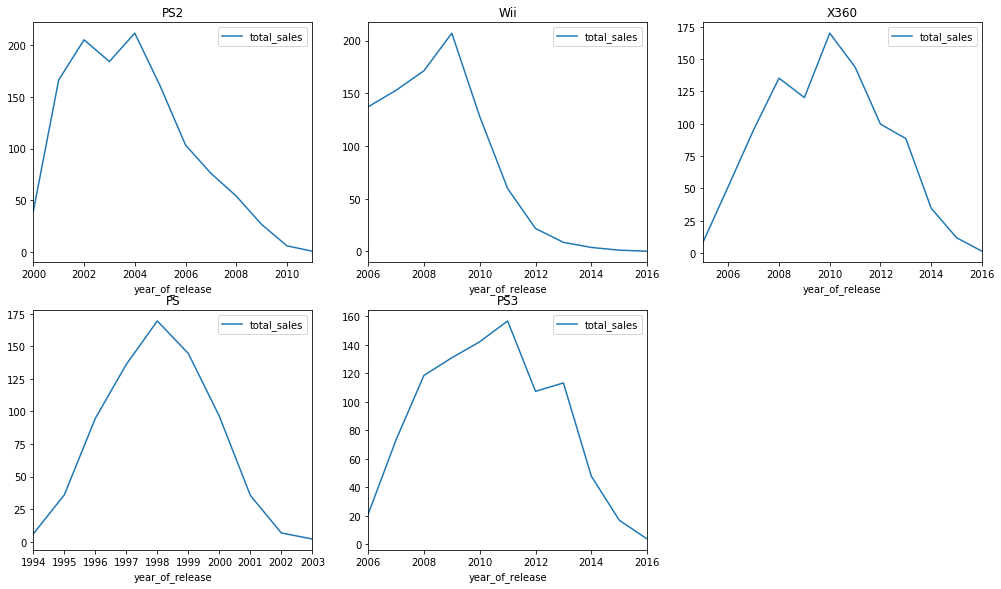

In [25]:
# выберем 10 наибольших суммарных продаж и из них топ платформ
#fg, ax = plt.subplots(2, 3, figsize=(15,7))
plt.subplots(figsize=(17,15))
platform_top = platform_grouped['platform'][:10].unique()
for i, platform in enumerate(platform_top):
    games.query('platform==@platform').pivot_table(index='year_of_release',
                                                  values='total_sales',
                                                  aggfunc='sum').plot(ax=plt.subplot(3, 3, i+1), 
                                                                      title=platform)

В результате мною были выбраны топ 5 платформ с наибольними суммарными продажами: `PS2, Wii, X360, PS, PS3`.\
Как видно выше, каждая из платформ достигала своего пика по продажам примерно через 5 лет после выхода.
Основываясь на графиках выше, можно сделать вывод о том, что средний срок жизни платформы составляет примерно **10 лет**.

In [26]:
platform_top

array(['PS2', 'Wii', 'X360', 'PS', 'PS3'], dtype=object)

Определим актуальный период для построения прогнозов на 2017 год.

In [27]:
games['year_of_release'].max()

2016

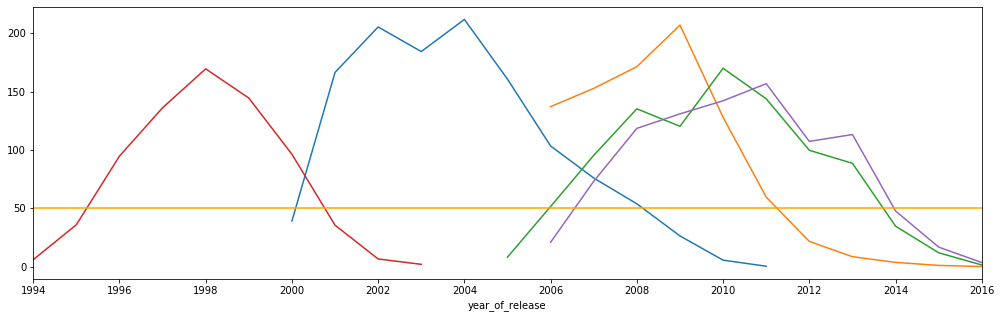

In [28]:
# изобразим графики вместе для большей наглядности
fg, ax = plt.subplots(figsize=(17,5))
platform_top = platform_grouped['platform'][:10].unique()
for platform in platform_top:
    games.query('platform==@platform').pivot_table(index='year_of_release',
                                                  values='total_sales',
                                                  aggfunc='sum').plot(ax=ax, legend=False)
plt.xticks(np.arange(1994, 2018, step=2))
plt.axhline(y = 50, color='orange')
plt.show()

Заметим, что у многих графиков есть длинные хвосты, обозначающие уменьшение продаж с 
платформы, вместе с тем и умирание платформы.\
Попробуем найти пороговое значение выручки, которое будет отсекать данные хвосты. По графику видно, что подходит значение близкое к 50. То есть если продажи с платформы больше 50

In [29]:
# найдем сколько в среднем живут платформы выше этого порога
sales_over_fifty = platform_grouped.query('(platform in @platform_top) and (total_sales > 50)').pivot_table(index='platform',
                                                                                                            values='year_of_release',
                                                                                                            aggfunc=['min', 'max']).reset_index()
sales_over_fifty['diff'] = sales_over_fifty['max'] - sales_over_fifty['min']
sales_over_fifty

,platform,min,max,diff
,,year_of_release,year_of_release,
0,PS,1996,2000,4
1,PS2,2001,2008,7
2,PS3,2007,2013,6
3,Wii,2006,2011,5
4,X360,2006,2013,7


In [30]:
avg_platform_life = sales_over_fifty['diff'].mean()
avg_platform_life

5.8

Таким образом, после проведенного анализа было выявлено, что **средняя жизнь платформы составляет примерно 6 лет**.\
То есть **актуальным периодом** можем считать промежуток с **2010** по **2016** года.

In [31]:
# отфильтруем данные 
filtered_games = games.query('2010 <= year_of_release <= 2016')
filtered_games.shape[0]/games.shape[0] *100

32.09073218195086

<a id='section3.1'></a>
Таким образом, осталось 32% от размера изначальных данных.\
**Посмотрим какие платформы лидируют по продажам за актуальный период.**

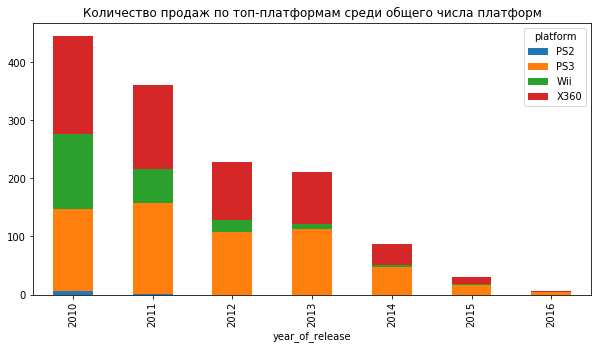

In [32]:
# построим гистаграммы продаж по топ-платформам среди общего числа платформ
filtered_games.query('platform in @platform_top').pivot_table(index='year_of_release',
                                                             values='total_sales',
                                                             columns='platform',
                                                             aggfunc='sum').plot(figsize=(10,5), kind='bar', stacked=True)
plt.title('Количество продаж по топ-платформам среди общего числа платформ')
plt.show()

Как видно на графике, **лидером продаж** за актуальный период является платформа **PS3**, хотя продажи *Xbox360* очень близки к продажам *PS3*. Далее располагается платформа *Wii*, продажи которой сильно убывают и сходят на нет к 2016 году. Практически нет продаж за актульный период у *PS2*.\
Продажи *PS3* имеют ведут себя перманентно: 
- возрастают в 2011 году;
- убывают в 2012
- немного возрастают в 2013 и далее убывают.

Продажи *Xbox360* с каждым годом постепенно убывают.\
Как можно заметить продажи каждой платформы постепенно падают, что говорит о снижении их популярности.

In [33]:
# составим новый топ платформ, соответсвующий актульному периоду
actual_platform_grouped = filtered_games.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum').reset_index()
actual_platform_grouped = actual_platform_grouped.sort_values(by='total_sales', ascending=False)
actual_platform_grouped[:10]

,platform,year_of_release,total_sales
54,X360,2010,170.03
20,PS3,2011,156.78
55,X360,2011,143.84
19,PS3,2010,142.17
42,Wii,2010,127.95
28,PS4,2015,118.90
22,PS3,2013,113.25
21,PS3,2012,107.36
27,PS4,2014,100.00
56,X360,2012,99.74


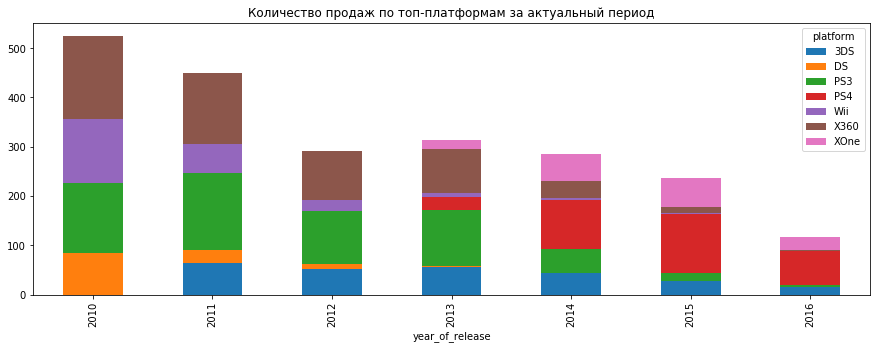

In [34]:
# определим новый топ платформ и построим гистограммы продаж 
# возьмем в этот раз 20 топ продаж
actual_platform_top = actual_platform_grouped[:20]['platform'].unique() 
fg, ax = plt.subplots(figsize=(15,5))
filtered_games.query('platform in @actual_platform_top').pivot_table(index='year_of_release',
                                                             values='total_sales',
                                                             columns='platform',
                                                             aggfunc='sum').plot(ax=ax, kind='bar', stacked=True)
plt.title('Количество продаж по топ-платформам за актуальный период')
plt.show()

Как видим, в топ платформ вошла новая платформа - *PS4*, которая вышла в 2013 году.\
В тот же год появилась и платформа *Xbox One*, но как видно на гистограммах ее продажи меньше, чем продажи платформы *PS4*.\
Основываясь на средней продолжительности "жизни" платформы, у этих двух платформ есть еще два года.

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.**

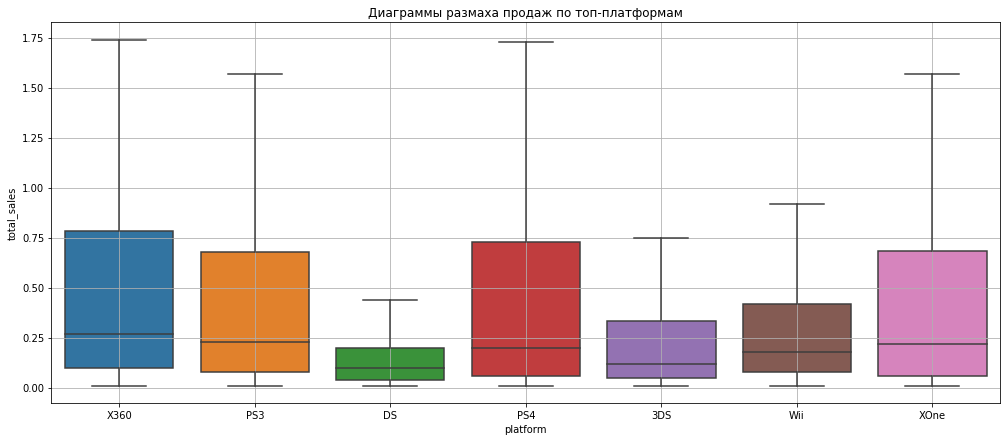

In [35]:
fg, ax = plt.subplots(figsize=(17,7))
sns.boxplot(x='platform',
            y='total_sales',
            data=filtered_games.query('platform in @actual_platform_top'),
            showfliers=False,
            ax=ax)
plt.grid(True)
plt.title('Диаграммы размаха продаж по топ-платформам')
plt.show()

In [36]:
# построим также таблицу количества выпущенных под платформу игр
# в таблицу также добавим медианные продажи
count_games = filtered_games.query('platform in @actual_platform_top').pivot_table(index='platform',
                                                                     values=['total_sales'],
                                                                     aggfunc=['count', 'median'])
count_games.columns = ['count_games', 'total_sales_median']
count_games.sort_values(by='count_games', ascending=False)

,count_games,total_sales_median
platform,,
PS3,889,0.23
X360,680,0.27
3DS,512,0.12
DS,507,0.10
Wii,450,0.18
PS4,392,0.20
XOne,247,0.22


Сделаем выводы по диаграммам и таблице. И график, и таблица подтверждают, что наибольшее медианное значение больше у *Xbox360*, несмотря на то, что игр для это платформы было выпущено меньше, чем для *PS3*. Такую же зависимость можно проследить и в случае платформ *XboxOne* и *PS4*: медиана продаж у первого больше, при этом количество игр меньше.

<a id='section3.2'></a>
**Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.**\
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

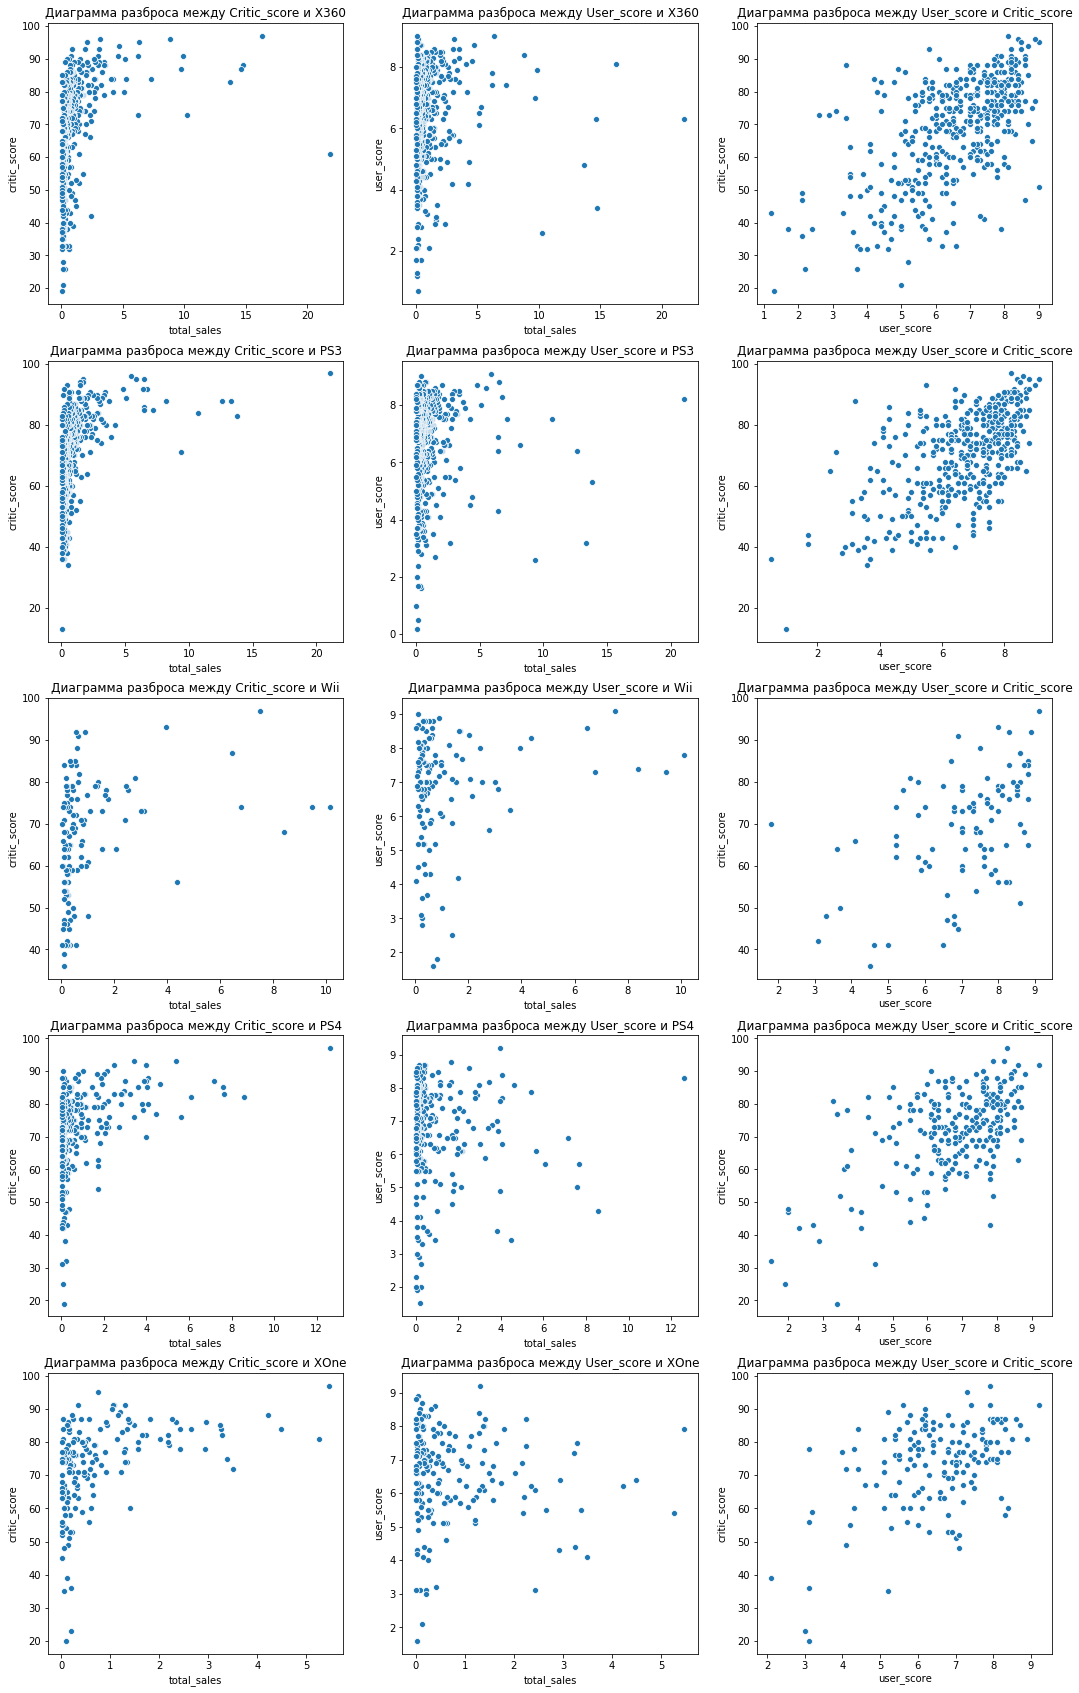

In [37]:
# сократим список топ-платформ и построим диаграммы-рассеивания сразу для всех платформ

actual_platform_top = np.array(['X360', 'PS3', 'Wii', 'PS4', 'XOne'])
n_rows = actual_platform_top.shape[0]
n_cols = 3
nfg, ax = plt.subplots(n_rows, n_cols, figsize=(18,30))
for i, platform in enumerate(actual_platform_top):
    data = filtered_games.query('platform==@platform')
    sns.scatterplot(x='total_sales',
                y='critic_score',
                data=data, 
                ax=ax[i][0])
    sns.scatterplot(x='total_sales',
                y='user_score',
                data=data,
                ax=ax[i][1])
    sns.scatterplot(x='user_score',
                    y='critic_score',
                    data=data,
                    ax=ax[i][2])
    ax[i][0].set_title('Диаграмма разброса между Critic_score и '+ platform)
    ax[i][1].set_title('Диаграмма разброса между User_score и '+ platform)
    ax[i][2].set_title('Диаграмма разброса между User_score и Critic_score')

In [38]:
# посмотрим на корреляцию между оценками и продажами
for platform in actual_platform_top:
    print('Корреляция между оценками и продажами игр на {}:'.format(platform))
    data = filtered_games.query('platform==@platform')
    print(data[['total_sales', 'user_score', 'critic_score']].corr())
    #print('Critic_score и Total_sales:', data['user_score'].corr(data['total_sales']))
    #print('User_score и Total_sales:', data['total_sales'].corr(data['critic_score']))
    print('------')

Корреляция между оценками и продажами игр на X360:
              total_sales  user_score  critic_score
total_sales      1.000000    0.066035      0.340064
user_score       0.066035    1.000000      0.597552
critic_score     0.340064    0.597552      1.000000
------
Корреляция между оценками и продажами игр на PS3:
              total_sales  user_score  critic_score
total_sales      1.000000    0.065092      0.400594
user_score       0.065092    1.000000      0.595259
critic_score     0.400594    0.595259      1.000000
------
Корреляция между оценками и продажами игр на Wii:
              total_sales  user_score  critic_score
total_sales      1.000000    0.147160      0.310588
user_score       0.147160    1.000000      0.471698
critic_score     0.310588    0.471698      1.000000
------
Корреляция между оценками и продажами игр на PS4:
              total_sales  user_score  critic_score
total_sales      1.000000   -0.031957      0.406568
user_score      -0.031957    1.000000      0.55765

In [39]:
data = filtered_games.query('platform=="XOne"') 
data['user_score'].corr(data['total_sales'])

-0.06892505328279414

Как видно по диаграммам рассеивания, большинство объектов получает оценки выше 50%.\
По полученной корреляционной таблице видно, что продажи коррелируют с оценкой критиков, коэффициент корреляции колеблется между 0,3 до 0,4. При этом практически нулевая зависимость между продажами и оценкой пользователей.\
Также я дополнительно посмотрел на зависимость между оценками пользователей и критиков. Как видно по графикам и коэффициентам корреляции, оценки зависимы между собой достаточо уверенно.

<a id='section3.3'></a>
**Посмотрим на общее распределение игр по жанрам.**

In [40]:
genre_grouped = filtered_games.pivot_table(index='genre',
                                           values='total_sales',
                                           aggfunc=['count', 'sum'])
genre_grouped.columns = ['games_count', 'total_sales_sum']
genre_grouped.sort_values(by='games_count', ascending=False)

,games_count,total_sales_sum
genre,,
Action,1495,673.09
Misc,576,234.56
Sports,575,328.39
Role-Playing,568,315.28
Adventure,563,61.00
Shooter,410,479.74
Racing,237,122.68
Simulation,217,71.75
Fighting,199,81.59


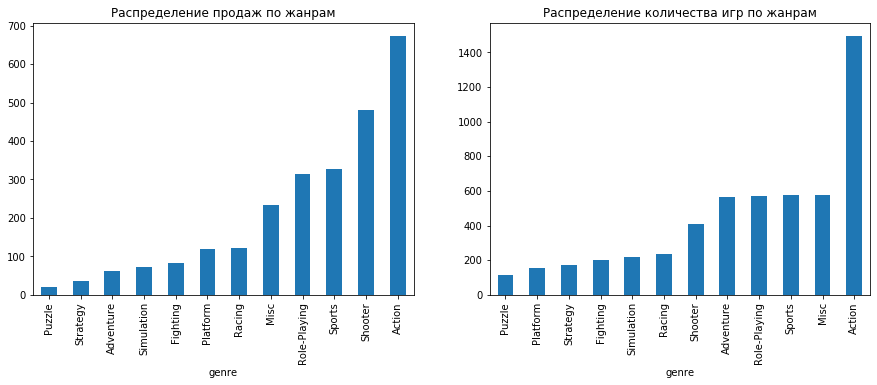

In [41]:
fg, ax = plt.subplots(1, 2, figsize=(15,5))
genre_grouped['total_sales_sum'].sort_values(ascending=True).plot(kind='bar',
                                                                  ax=ax[0], 
                                                                  title='Распределение продаж по жанрам')
genre_grouped['games_count'].sort_values(ascending=True).plot(kind='bar', 
                                                              ax=ax[1],
                                                              title='Распределение количества игр по жанрам')
plt.show()

Очевидным лидером среди жанров игр является жанр `Action`, особенно это выделяется по количеству игр этого жанра.\
Также стоит заметить, что несмотря на то, что жанр `Shooter` не входит в топ-5 по количеству игр, он занимает вторую позицию по количеству продаж.\
Практически на одном уровне находятся продажи таких жанров, как `Misc, Sports, Role_playing, Adventure`.\
Самые низкие показатели у жанра `Puzzle`.\
К топу жанров, помимо жанра `Action`, можно отнести жанры `Shooter, Sports, Role-Playing, Misc`.

<a id='section4'></a>
### Составим портрет пользователя каждого региона

**Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5).**

,eu_sales,jp_sales,na_sales,other_sales
platform,,,,
3DS,0.072836,0.329750,0.073115,0.049611
DS,0.033357,0.091433,0.052777,0.030395
PC,0.081811,0.000000,0.034563,0.052602
PS2,0.001985,0.002622,0.002052,0.004860
PS3,0.253920,0.194206,0.202803,0.320136
PS4,0.167723,0.052304,0.096195,0.180761
PSP,0.009023,0.138297,0.008537,0.017235
PSV,0.015537,0.071574,0.011031,0.024039
Wii,0.078351,0.058170,0.107218,0.067706


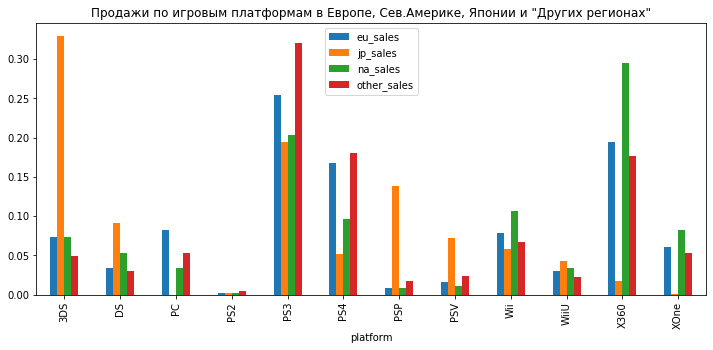

In [42]:
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
regions_grouped = filtered_games.pivot_table(index='platform',
                                            values=regions,
                                            aggfunc='sum')
for col in regions_grouped:
    regions_grouped[col] = regions_grouped[col] / regions_grouped[col].sum()
regions_grouped.plot(kind='bar', figsize=(12,5), title='Продажи по игровым платформам в Европе, Сев.Америке, Японии и "Других регионах"')
regions_grouped

In [43]:
# теперь определим популярные платформы для каждого региона
regions_grouped = regions_grouped.reset_index()
platform_top_region = {}
for region in regions:
    top_five = regions_grouped.sort_values(by=region, ascending=False)['platform'].unique()[:5]
    platform_top_region[region] = top_five
pd.DataFrame(platform_top_region)

,na_sales,eu_sales,jp_sales,other_sales
0,X360,PS3,3DS,PS3
1,PS3,X360,PS3,PS4
2,Wii,PS4,PSP,X360
3,PS4,PC,DS,Wii
4,XOne,Wii,PSV,XOne


Как видно по итоговой таблице, для всех регионов, кроме Японии, топ платформ сходится с общим топом, это игровые консоли `Xbox360, PS3, Wii, PS4, XboxOne`.\
В Японии же большую популярность имеют портативные игровые консоли: 4 позиции из топ-5 заняли приставки именного такого вида. Среди обычных консолей в топ вошла только `PS3`.
Если смотреть в разрезе платформ, то `PS3` для каждого из регионов занимет не менее 20% рынка, в особенности для Европы и "других регионов".\
В Японии более 30% рынка продаж занимает платформа `Nintendo 3DS`, при этом в данном регионе `PC` имеет нулевую долю (возможно, это связано с тем, что не было данных по продажам игр для `PC` в Японии).\
Что касается Северной Америки, то чуть меньше 30% от рынка продаж занимает игровая консоль `Xbox360`.\
Во всех регионах практически нулевые доли от всего рынка имеет приставка `PS2`.

**Определим для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5).** 

,eu_sales,jp_sales,na_sales,other_sales
genre,,,,
Action,0.277731,0.236613,0.257110,0.286451
Adventure,0.022444,0.051353,0.018436,0.020974
Fighting,0.024168,0.045553,0.034545,0.031068
Misc,0.078565,0.079603,0.109518,0.076193
Platform,0.045530,0.051812,0.048566,0.040040
Puzzle,0.007822,0.011142,0.008050,0.005683
Racing,0.065085,0.021892,0.040791,0.056602
Role-Playing,0.089728,0.339320,0.099123,0.090511
Shooter,0.203814,0.046012,0.210074,0.212278


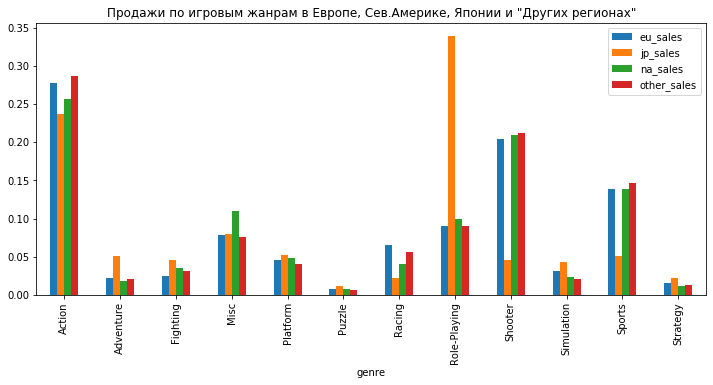

In [44]:
genre_grouped_region = filtered_games.pivot_table(index='genre',
                                                 values=regions,
                                                 aggfunc='sum')
for region in regions:
    genre_grouped_region[region] = genre_grouped_region[region] / genre_grouped_region[region].sum() 
genre_grouped_region.plot(kind='bar', figsize=(12, 5), title='Продажи по игровым жанрам в Европе, Сев.Америке, Японии и "Других регионах"')
genre_grouped_region

In [45]:
# теперь определим популярные жанры для каждого региона
genre_grouped_region = genre_grouped_region.reset_index()
genre_top_region = {}
for region in regions:
    top_five = genre_grouped_region.sort_values(by=region, ascending=False)['genre'].unique()[:5]
    genre_top_region[region] = top_five
pd.DataFrame(genre_top_region)

,na_sales,eu_sales,jp_sales,other_sales
0,Action,Action,Role-Playing,Action
1,Shooter,Shooter,Action,Shooter
2,Sports,Sports,Misc,Sports
3,Misc,Role-Playing,Platform,Role-Playing
4,Role-Playing,Misc,Adventure,Misc


Аналогично с предыдущим пунктом, топ жанров по регионам совпадает с общим топом.\
В частности, можно заметить, что топ по Европе и "другим регионам" абсолютно идентичен.\
Северо-американский топ жанров практически такой же, как и европейский, за исключением разных позиций `Misc` и `Role-Playing`.\
Японский топ немного отличается, но также имеет общие жанры с остальными регионами.\
Если смотреть на доли жанров на игровом рынке каждого региона, то большАя доля рынка каждого региона у жанра `Action`, от 20% до 30%.\
На японском рынке абсолютное лидерство держит жанр `Role-Playing`, который занимает чуть меньше 35% рынка.\
В Европе, Северной Америке и "других регионах" примерно 70% рынка забрали жанры `Action, Shooter` и `Sports`.

**Определим влияет ли рейтинг ESRB на продажи в отдельном регионе.**

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,0.234591,0.156879,0.239869,0.224465
E10+,0.118020,0.043324,0.140993,0.116457
EC,0.000000,0.000000,0.001000,0.000262
M,0.347167,0.099790,0.338125,0.362569
RP,0.000036,0.000000,0.000000,0.000037
T,0.134425,0.138002,0.142258,0.144758
notdef,0.165761,0.562004,0.137755,0.151451


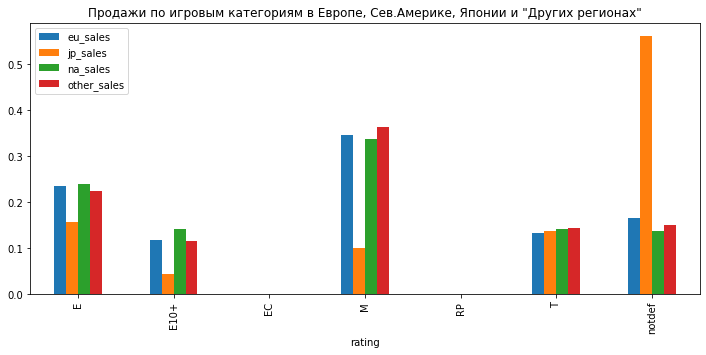

In [46]:
rating_grouped_region = filtered_games.pivot_table(index='rating',
                                                 values=regions,
                                                 aggfunc='sum')
for region in regions:
    rating_grouped_region[region] = rating_grouped_region[region] / rating_grouped_region[region].sum()
rating_grouped_region.plot(kind='bar', figsize=(12, 5), title='Продажи по игровым категориям в Европе, Сев.Америке, Японии и "Других регионах"')
rating_grouped_region

Основываясь на графике выше, можно сделать вывод, что самые большие доли на рынке продаж в Европе, Сев.Америке и "других регионах" имеют игры категории `M (Mature)`, при этом в Японии игры данной категории занимают около 10%.\
Также отметим, что 56% японского рынка занимают игры, по которым нет информации о возрастной категории.\
На мой взгляд, рейтинг *ESRB* влияет на продажи в регионах, так как возрастная категория зависит от жанра игры, а так как первые 2 позиции в топе жанров в Европе, Северной Америке и "других регионах" занимают жанры `Action` и `Shooter`, то соответственно большинство из них имеют категорию `M`.

Подытоживая проведенный анализ по регионам, можно сказать, что рынок (портрет пользователя) Европы, Северной Америки и "других регионов" похож между собой, об этом говорит и топ игровых консолей, и топ жанров, и влияние возрастной категории. То есть предпочтения пользователей данных регионов очень похожи.\
Что касается Японии, то ее рынок немного отличается от игровых рынков других регионов. Все-таки Восток - дело тонкое)

<a id='section5'></a>
### Проверим гипотезы

<a id='section5.1'></a>
**1. Проверим, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

**Нулевая гипотеза:** средние пользовательские рейтинги платформ Xbox One и PC равны.\
**Альтернативная гипотеза:** средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [47]:
# отфильтруем данные, будем смотртеть оценки за актуальное время

xbox_data = filtered_games.query('platform=="XOne"').dropna(subset=['user_score'])
pc_data = filtered_games.query('platform=="PC"').dropna(subset=['user_score'])

# для начала проведем оценку дисперсий выборок, чтобы верно подобрать параметр equal_var
var_1 = xbox_data['user_score'].var()
var_2 = pc_data['user_score'].var()
diff = abs(var_1 - var_2) / var_1 * 100
eq_var = True
if diff > 5:
    eq_var = False
    print('Отличие значимо.')
else:
    print('Отличие незначительно.')

# возьмем уровень стат.значимости за 5%
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
    xbox_data['user_score'], 
    pc_data['user_score'],
    equal_var = eq_var)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отличие значимо.
p-значение: 0.9801634129117883
Не получилось отвергнуть нулевую гипотезу


**Вывод:** нулевую гипотезу отвергнуть не удалось, поэтому средние пользовательские рейтинги платформ Xbox One и PC равны.\
В данном случае гипотеза двусторонняя, так как нам не важно меньше ли среднее какой-либо величины или больше, важно только то, что оно равно или различается. Нулевая гипотеза всегда формируется о равенстве средних, альтернативная - наоборот.

<a id='section5.2'></a>
**2. Проверим, что средние пользовательские рейтинги жанров Action и Sports разные.**

**Нулевая гипотеза:** средние пользовательские рейтинги жанров Action и Sports равны.\
**Альтернативная гипотеза:** средние пользовательские рейтинги жанров Action и Sports разные.

In [48]:
# отфильтруем данные

action_data = filtered_games.query('genre=="Action"').dropna(subset=['user_score'])
sports_data = filtered_games.query('genre=="Sports"').dropna(subset=['user_score'])

# для начала проведем оценку дисперсий выборок, чтобы верно подобрать параметр equal_var
var_1 = action_data['user_score'].var()
var_2 = sports_data['user_score'].var()
diff = abs(var_1 - var_2) / var_1 * 100
eq_var = True
if diff > 5:
    eq_var = False
    print('Отличие значимо.')
else:
    print('Отличие незначительно.')

# возьмем уровень стат.значимости за 5%
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
    action_data['user_score'], 
    sports_data['user_score'],
    equal_var=eq_var)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отличие значимо.
p-значение: 1.4516152467844418e-15
Отвергаем нулевую гипотезу


**Вывод:** отвергаем нулевую гипотезу, принимаем альтернативную, то есть средние пользовательские рейтинги жанров Action и Sports разные.\
В данном случае гипотеза также двусторонняя.

<a id='section6'></a>
### Общий вывод

В конечном итоге мною были проанализированы данные о продажах игр, оценках пользователей и экспертов, жанрах и платформах.
На первом этапе был проведен первичный взгляд на данные. Далее они были обработаны. Так было выявлено, что пропущена практически половина данных об оценках пользователей и критиков, а также данные о возрастных категориях. Также у признаков *critic_score, user_score* и *year_of_release* был заменен тип данных на соответствующий.\
На следующем этапе было определено, что для исследования необходимы данные только за определенный период. Также было решено рассматривать только самые популярные платформы, такие как `PS3, PS4, Wii, Xbox360, XboxOne`. Так определено, что платформа "живет" примерно 10 лет, однако, они медленно "умирают", поэтому были отрезаны данные за ненужный период и в следствие определен а средняя продолжительность существования платформы - 6 лет.\
Так как нам необходимо делать прогноз на будущее, то лучшим решением представилось взять данные только за актуальный период, то есть с 2010 по 2016 года.\
Лидерами среди игровых консолей за актуальный период стали `PS3` и `Xbox360`.\
Далее было рассмотрено: влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Так, определено, что продажи и оценки критиков зависимы между собой.\
Затем были рассмотрены жанры игр. Абсолютным лидером среди жанров стал `Action` (и по количеству игр, и по количеству продаж). В топ также вошли жанры `Shooter, Sports, Misc, Role-Playing`.\
На следующем этапе был проведен анализ продаж по регионам и их зависимость от других факторов. Было выявлено, что показатели *Европы, Северной Америки и отдельной категории "другие регионы"* очень схожи между собой. Только Япония отличается от всех остальных: это касается и жанров, и платформ, и возрастных категорий. Было замечено, что большой популярностью на японском рынке пользуются портативные игровые приставки (*3DS, DS, PSP, PSV*).\
На последнем этапе были проверены две гипотезы, в следствие чего принято, что средние пользовательские рейтинги платформ Xbox One и PC равны, а также, что средние пользовательские рейтинги жанров Action и Sports разные.\
В итоге, мною были найдены следующие определяющие успешность игры закономерности:\
- **платформа:** для того, чтобы игра была успешной она должна быть разработана в первую очередь под платформы Playstaytion и Xbox. На данный момент это два лидера среди стационарных игровых консолей. Чтобы обрести успех на японском рынке, необходимо, учесть, что там популярны переносные игровые приставки.
- **жанр:** игра также будет иметь шанс на успех, если ее жанр будет `Action`. На данный момент игры именно этого жанра имеют высокую популярность среди пользователей. Также определенный успех могут иметь игры жанра `Shooter, Sports, Misc` или `Role_Playing`.
- **оценки пользователей и критиков:** по проведенному анализу было замечено, что оценки критиков могут повлиять на успешность игры, точнее: чем выше оценки критиков, тем лучше для игры.
- **возрастная категория:** по моему мнению, данный фактор не слишком влияет на успешность игры, хотя было замечено, что игры категории `M` занимают долю игрового рынка больше всего. Мне кажется, что данный критерий необходимо изучить более детально.